# Tarea 3 - Computación Cienctífica y Ciencia de los Datos
## Flujo de Agua
### Vicente Mieres / 21.082.122-8

## 1. Introducción

En el presente informe, se detalla la implmentacion de un simulador bidimencional de un flujo incomprensible, resolviendo las ecuaciones de Navier-Stokes y la ecuación de Poisson para la presión, utilizando el método de diferencias finitas.

El sistema simula un flujo de fluido en un canal rectangular con un obstáculo circular fijo, e incluye:

    - Fricción interna del fluido (viscosidad)
    - Presión como variable
    - Entrada constante de flujo desde el borde izquierdo
    - Paredes móviles en la parte superior e inferior
    - Evaluación visual del comportamiento del flujo
    - Evaluación de la fuerza en el tiempo sobre el objeto
    - Análisis del correcto funcionamiento durante el tiempo -> Evaluar momento de fallo

## 2. Desarrollo

A continuación se detallan las consideraciones para poder implementar el autómata generalizado, tanto en su versión iterativa como en la optimizada.

### 2.1 Librerías

Para llevar a cabo el objetivo planteado, es necesario utilizar diferentes librerías.

- **NumPy**: Encargada de la creación y manipulación de arreglos multidimensionales, operaciones vectorizadas, entre otros.
- **matplotlib.pyplot**: Biblioteca de visualización. Creación de graficas.

In [74]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from scipy.ndimage import binary_dilation


### 2.2 Desarrollo del simulador

En primer lugar, y tal como se especifica en el enunciado, se utilizará como base el código perteneciente a @LoreanABarba (disponible en https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/15_Step_12.ipynb), este modela el flujo de cierto fluido utilizando las ecuaciones de Navier-Stokes en un canal, es decir con fluido de entrada por la izquierda y de salida por la derecha. Sin embargo es necesario realizar ciertas modificaciones al código para ajustarlo a las restricciones del enunciado, tales como agregar el obstaculo en medio del canal o parametrizar ciertos valores. Estos cambios serán especificados en su respectiva función.

#### 2.2.1 build_up_b()

Esta función es la encargada de contuir la  matríz *b*, la cual forma parte de la ecuación de Poisson, parte escencial del problema. En esta función el único cambio realizado, es la eliminación de las condiciones periódicas del problema que no son utilizadas en el nuevo contexto. Ningun otro cambio significativo es realizado.

In [49]:
def build_up_b(rho, dt, u, v, dx, dy):
    """
    Construye el término del lado derecho de la ecuación de Poisson para la presión a partir de los campos de velocidad u y v.

    Parameters:
     - rho : Densidad del fluido.
     - dt : Paso temporal.
     - u : Componente horizontal de la velocidad.
     - v : Componente vertical de la velocidad.
     - dx : Tamaño de celda en x.
     - dy : Tamaño de celda en y.
    Returns:
     - b : Matriz del término fuente para la ecuación de Poisson.
    """
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = rho * ((1/dt) * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx) + 
                                     (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy)) - 
                         ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2*dx))**2 - 
                         2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2*dy) * 
                              (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2*dx)) - 
                         ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2*dy))**2)

    return b

#### 2.2.2 pressure_poisson()

Esta función es la encargada de resolver la ecución de Poisson. De la misma forma que la función anterior se eliminó la componente de periocidad del problema, pues no genera cambio alguno. Sin embargo, si se consideran dos cambios en las condiciones de las paredes del problema, en particular las lineas que contienen el siguiente código:
- *p[0, :] = p[1, :]*
- *p[-1, :] = p[-2, :]*

El rol de estas lineas es modificar las condiciones de como interactúa la presión en las parades del problema. La primera de estas limita la pared superior (up), mientras que la segunda la pared inferior (down), de tal forma que se ajuste al hecho de que el fluido solamente se arrastra en horizontal y no hay fluctuaciones en vertical. El resto de condiciones del problema se mantienen intactas (entrada sin variación y velocidad cte. y sailda sin restricciones).


In [50]:
def pressure_poisson(p, b, dx, dy, nit=50):
    """
    Resuelve la ecuación de Poisson para el campo de presión `p` utilizando un método iterativo 

    Parameters:
    p : Campo inicial de presión.
    b : Lado derecho de la Ecuación.
    dx : Tamaño de celda en x.
    dy : Tamaño de celda en y.
    nit : Número de iteraciones para el método iterativo (default 50).

    Returns:
    p : ndarray
        Campo de presión actualizado.
    """
    pn = np.empty_like(p)
    for _ in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (
            (dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) +
             dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1]) -
             b[1:-1, 1:-1] * dx**2 * dy**2)
            / (2 * (dx**2 + dy**2))
        )

        p[:, -1] = p[:, -2]  # salida
        p[:, 0] = p[:, 1]    # entrada
        p[0, :] = p[1, :]    # pared inferior
        p[-1, :] = p[-2, :]  # pared superior
    return p

#### 2.2.3 simulation()

La siguiente función es la encargada de realizar la simulación completa, es decir calcular la ecuación de poisson con las funciones anteriores y actualizar las condiciones de las velocidades. Si bien esta parte del código también forma parte de la fuente original, se realizaron cambios en esta. En primer lugar se creó la función *simulation()*, simplemente para mantener un orden y poder reutilizar el código. Además, esta funcion incializa todos los parámetros necesarios para el correcto funcionamiento del programa, ya sea el porte de la caja (ancho y alto), vectores necesarios para las velocidades, tamaño del obstaculo, paso temporal, viscosidad, entre otros. Los unicos parámetros extra en este caso son

- d: Distancia de la pared izquierda del obstáculo
- u0: velocidad inicial

Además se realizaron dos cambios significativos respecto del código original.

- Parametrización de la velocidad: Esto es, la adición de la variable *u0*, la cual representa cual será la velocidad incial de entradad del fluido, y por tanto la velicidad en que se desplazan las paredes móviles *up* y *down*. Este cambio se ve reflejado dentro de la función bajo el comentario de == Condiciones de borde ==. Particularmente en la pared inferior, superior y entrada (lado izquierdo).
- Obstáculo: Incorporación de un obstáculo estático que afectará la trayectoria y presión del fluido. Esto se hace mediante un máscara booleana de radio *r = a / 25* y distancia *d* del lado izquierdo de la caja, este se incorpora en la simulación de la siguiente forma.
    1.  u[obstacle_mask] = 0
    2.  v[obstacle_mask] = 0

    Es decir, que sobre la superficie del cuerpor el fluido no puede entrar ni moverse.

In [93]:
def simulation(a, b, d, u0, nu, nx = 41, ny = 41, nt=100):

    """
    Ejecuta una simulación bidimensional del flujo de un fluido incompresible alrededor de un obstáculo circular en un canal rectangular

    Parameters:
    a : Altura del canal.
    b : Ancho del canal.
    d : Distancia del centro del obstáculo desde el borde izquierdo.
    u0 : Velocidad de entrada y de las paredes móviles.
    nu : Viscosidad cinemática del fluido.
    nx : Número de puntos en la dirección x (default = 41).
    ny : Número de puntos en la dirección y (default = 41).
    nt : Número de iteraciones.

    Returns:
    u : Componente horizontal del campo de velocidad.
    v : Componente vertical del campo de velocidad.
    p : Campo de presión.
    X : Malla de coordenadas X para visualización.
    Y : Malla de coordenadas Y para visualización.
    stepcount : Número de iteraciones realizadas hasta la convergencia.
    """

    rho = 1   # densidad 
    dx = b / (nx - 1)
    dy = a / (ny - 1)
    dt = 0.01  # paso temporal
    F = 1

    # Creación de malla
    x = np.linspace(0, b, nx)
    y = np.linspace(0, a, ny)
    X, Y = np.meshgrid(x, y)

    # Dimensiones del obstáculo
    r = a / 25
    xc = d
    yc = a / 2
    obstacle_mask = (X - xc)**2 + (Y - yc)**2 <= r**2

    obstacle_edge = binary_dilation(obstacle_mask) & (~obstacle_mask)

    # Inicialización de vectores
    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    p = np.zeros((ny, nx))

    udiff = 1
    stepcount = 0

    forces = []
    states = []

    while udiff < nt:

        un = u.copy()
        vn = v.copy()

        b = build_up_b(rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, b, dx, dy)

        force_t = np.sum(p[obstacle_edge]) * dx * dy  # Integral de presión en el borde
        forces.append(force_t)

        # Actualizar las velocidades utilizando la fórmula de Navier-Stokes
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) * 
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                        F * dt)

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
            un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
            vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
            dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
            nu * (dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # Incorporacion del Obstáculo 
        u[obstacle_mask] = 0
        v[obstacle_mask] = 0

        # Condiciones de borde 
        u[:, 0]  = u0       # entrada 
        u[:, -1] = u[:, -2] # salida
        v[:, 0]  = 0
        v[:, -1] = 0

        u[0, :]  = u0       # pared inferior
        u[-1, :] = u0       # pared superior
        v[0, :]  = 0
        v[-1, :] = 0

        # udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        udiff = udiff + 1
        stepcount += 1
        states.append((u.copy(), v.copy(), p.copy())) # linea solo necesaria para la animacion

    return u, v, p, X, Y, stepcount, forces, states, obstacle_mask, xc, yc, r


Text(0, 0.5, 'Y')

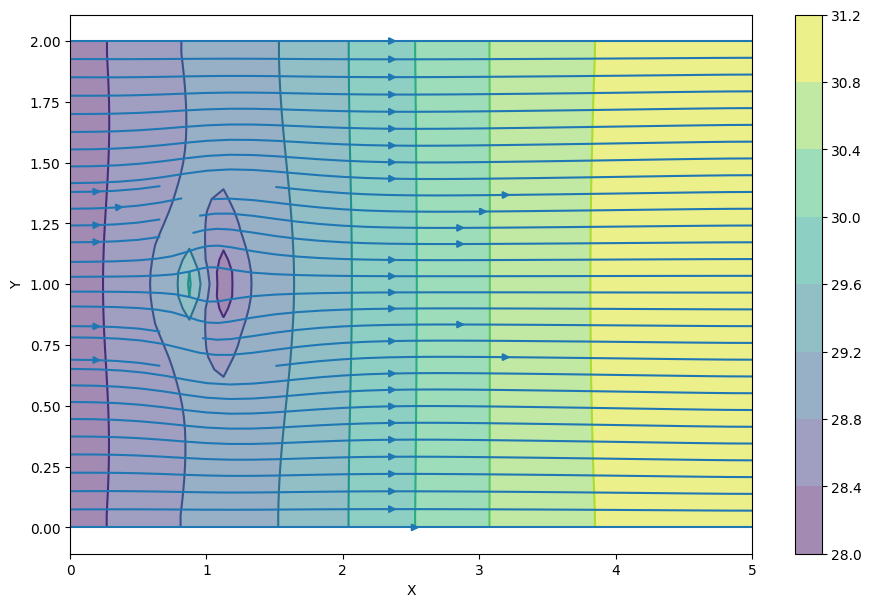

In [94]:
# ==== Visualización final ====
u, v, p, X, Y, sc, forces, states, om, xc, yc, r = simulation(2, 5, 1, 1, 0.09, nt=70)


fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y')



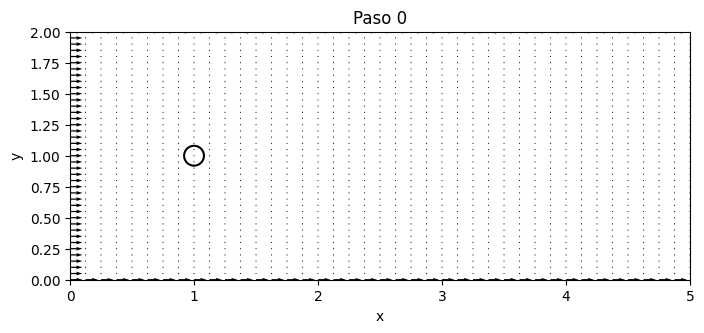

In [96]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# Crear figura
fig, ax = plt.subplots(figsize=(8, 4))

def animate(i):
    ax.clear()
    u, v, _ = states[i]

    # Dibujar campo vectorial con quiver
    ax.quiver(X, Y, u, v, scale=50, width=0.002, headwidth=3)

    # Dibujar el círculo como contorno perfecto del obstáculo
    circle = patches.Circle((xc, yc), r, color='k', fill=False, linewidth=1.5)
    ax.add_patch(circle)

    # Ajustes visuales
    ax.set_title(f"Paso {i}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0, X.max())
    ax.set_ylim(0, Y.max())
    ax.set_aspect('equal')

    return []

# Crear animación
ani = animation.FuncAnimation(fig, animate, frames=len(states), interval=80, blit=False)

# Mostrar en notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

ani.save('flujo_quiver.gif', writer='pillow', fps=12)



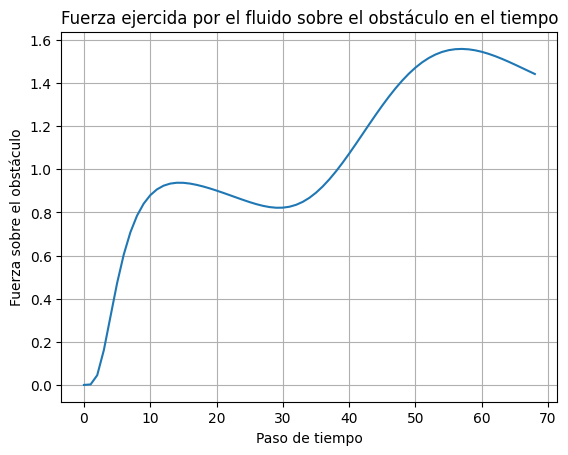

In [91]:
plt.plot(forces)
plt.xlabel("Paso de tiempo")
plt.ylabel("Fuerza sobre el obstáculo")
plt.title("Fuerza ejercida por el fluido sobre el obstáculo en el tiempo")
plt.grid(True)
plt.show()
